# Policing Disparities Plots - Error Bars from Bootstrapping
This notebook contains code to generate the plots in our paper, using data from a bootstrapping process. 

In [188]:
from pprint import pprint
from pathlib import Path
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib
from glob import glob 
import json


### LaTeX font rendering (optional, requires local LaTeX installation)

In [189]:
# Requires local LaTeX installation 
rc('font', **{'family': 'serif', 'serif': ['Computer Modern Roman']})
matplotlib.rcParams['text.usetex'] = True
rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage[T1]{fontenc}')

## Directory verification / setup
This code should work by default, assuming the directory layout in the Git repo is unchanged. 

In [190]:
BOOTSTRAPS_PATH = "../plot_data"
PLOTS_PATH = "../plot/figures"

In [191]:
p = Path(PLOTS_PATH)
if not p.is_dir():
    print("plots directory is empty, creating now...")
    p.mkdir()    

In [192]:
pprint(glob(f"{BOOTSTRAPS_PATH}/*.json"))

['../plot_data/boro_bootstraps.json',
 '../plot_data/density_cbg_bootstraps.json',
 '../plot_data/density_cbg_residential_only_bootstraps.json',
 '../plot_data/median_household_income_bootstraps.json',
 '../plot_data/median_household_income_residential_only_bootstraps.json',
 '../plot_data/neighborhood_bootstraps.json',
 '../plot_data/race_bootstraps.json',
 '../plot_data/race_residential_zones_only_bootstraps.json',
 '../plot_data/zone_bootstraps.json']


In [193]:
def bootstrapped_plots(label_mapping={},data_path="", firstn_filter=-1, lastn_filter=-1, figsize=(5,4)):
    data = json.load(open(data_path))
     
    
    point_estimate = pd.DataFrame.from_dict(data['point_estimate'], orient='index')
    point_estimate = point_estimate[point_estimate.index.map(lambda x: 'relative_to_average' in x)]
    point_estimate = point_estimate.sort_values(by=0)[::-1]
    if len(label_mapping) > 0:
        point_estimate.index = point_estimate.index.map(label_mapping)
        point_estimate = point_estimate.loc[point_estimate.index.dropna()]
    bootstraps = pd.DataFrame.from_dict(data['bootstrap_statistics'])

    assert len(bootstraps.index) >= 20
    
    std_errs = bootstraps.std() * 1.96
    
    std_errs = std_errs[std_errs.index.map(lambda x: 'relative_to_average' in x)]
    if len(label_mapping) > 0:
        std_errs.index = std_errs.index.map(label_mapping)
        std_errs = std_errs.loc[std_errs.index.dropna()]
    
    if (firstn_filter > -1) & (lastn_filter > -1):
        point_estimate = pd.concat([point_estimate.iloc[:firstn_filter], point_estimate.iloc[-lastn_filter:]])
        std_errs = pd.concat([std_errs.iloc[:firstn_filter] , std_errs.iloc[-lastn_filter:]])
    elif firstn_filter > -1: 
        point_estimate = point_estimate[:firstn_filter]
    elif lastn_filter > -1: 
        point_estimate = point_estimate[-lastn_filter:]
    
    
    
    
    
    fig, ax = plt.subplots(figsize=figsize)
    
    colors_array = point_estimate.iloc[:,0].apply(lambda x: '#FFE77AFF' if x > 1 else '#2C5F2DFF')
    
    if abs(1-min(point_estimate.iloc[:,0])) > abs(max(point_estimate.iloc[:,0])-1):
        most_divergent_tick = point_estimate.idxmin()
    else: 
        most_divergent_tick = point_estimate.idxmax()
    
    yticks = [round(1/point_estimate.loc[most_divergent_tick].values[0][0],2), 1, round(point_estimate.loc[most_divergent_tick].values[0][0],2)]
    yticks.sort()

    ax.set_xlim(-0.5,len(point_estimate)-0.5)
    ax.vlines(x=point_estimate.index, ymax=point_estimate, ymin=1, linewidth=40, colors=colors_array)
    ax.set_ylabel('Calibrated Probability of Police Exposure, \n relative to average')
    ax.errorbar(y=point_estimate.iloc[:,0], x=point_estimate.index, yerr=std_errs, ls='None', capsize=5, capthick=0.5, elinewidth=1, ecolor='black')
    ax.axhline(1, color='black', linewidth=0.8, linestyle='--', alpha=0.7)
    
    ax.set_yscale('log', subs=[0])
    ax.set_yticks(yticks)
    ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%0.2fx'))
    
    for tick in ax.xaxis.get_major_ticks()[1::2]:
        tick.set_pad(15)
    
    return fig, ax

## Disparities by race plot code 

In [194]:
RACE_DATA_PATH = f"{BOOTSTRAPS_PATH}/race_bootstraps.json"

In [195]:
race_data_mapping = {
    'Estimate_Total_Not_Hispanic_or_Latino_White_alone_relative_to_average': 'White',
    'Estimate_Total_Not_Hispanic_or_Latino_Black_or_African_American_alone_relative_to_average': 'Black',
    'Estimate_Total_Hispanic_or_Latino_relative_to_average': 'Hispanic',
    'Estimate_Total_Not_Hispanic_or_Latino_Asian_alone_relative_to_average': 'Asian'
}

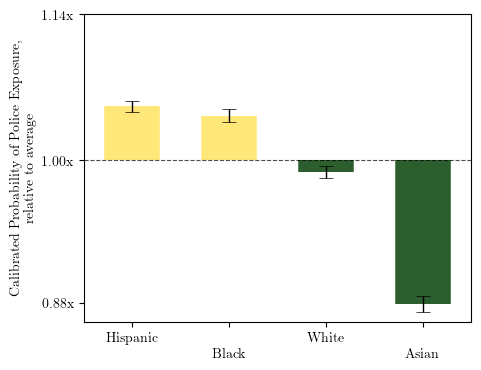

In [196]:
fig, ax = bootstrapped_plots(label_mapping=race_data_mapping, data_path=RACE_DATA_PATH)
plt.savefig(f'{PLOTS_PATH}/bootstrapped_race_plot.jpg', bbox_inches="tight")

## Disparities by race (only residential zones) plot code 

In [197]:
RACE_RZONE_DATA_PATH = f"{BOOTSTRAPS_PATH}/race_residential_zones_only_bootstraps.json"

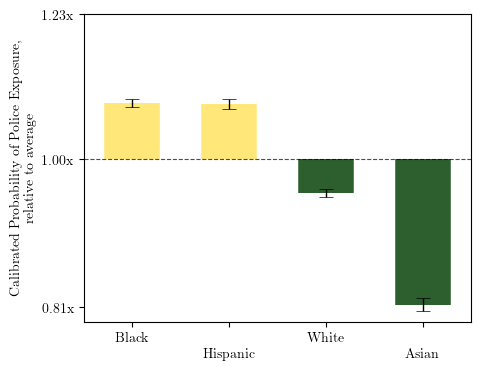

In [198]:
fig, ax = bootstrapped_plots(data_path=RACE_RZONE_DATA_PATH, label_mapping=race_data_mapping)
plt.savefig(f'{PLOTS_PATH}/bootstrapped_race_rzones_plot.jpg', bbox_inches="tight")

## Disparities by zone plot code

In [199]:
ZONE_DATA_PATH = f"{BOOTSTRAPS_PATH}/zone_bootstraps.json"

In [200]:
zone_label_mapping = {
    "C_relative_to_average": "Commercial",
    "M_relative_to_average": "Manufacturing",
    "R_relative_to_average": "Residential"
}

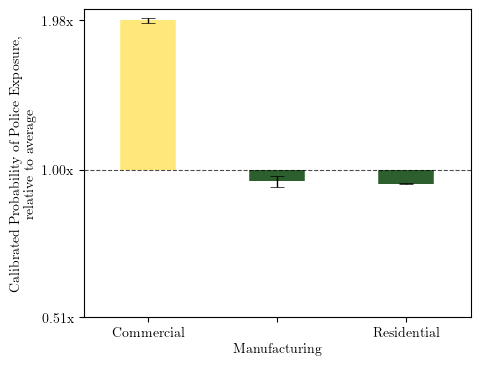

In [201]:
fig, ax = bootstrapped_plots(data_path=ZONE_DATA_PATH, label_mapping=zone_label_mapping)
plt.savefig(f'{PLOTS_PATH}/bootstrapped_zone_plot.jpg', bbox_inches="tight")

## Disparities by income plot code 

In [202]:
INCOME_DATA_PATH = f"{BOOTSTRAPS_PATH}/median_household_income_bootstraps.json"

In [203]:
income_label_mapping = { 
    "median_household_income_quartile_1_relative_to_average": "MHI, Q1",    
    "median_household_income_quartile_2_relative_to_average": "MH1, Q2",   
    "median_household_income_quartile_3_relative_to_average": "MH1, Q3",    
    "median_household_income_quartile_4_relative_to_average": "MH1, Q4"
}

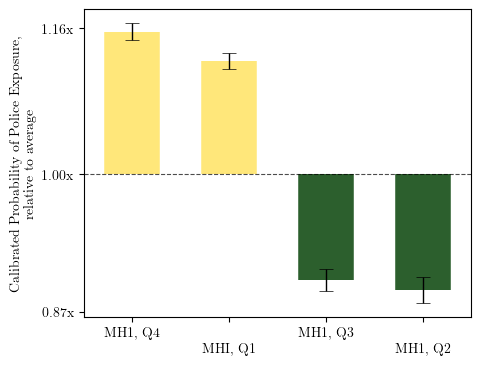

In [204]:
fig, ax = bootstrapped_plots(data_path=INCOME_DATA_PATH, label_mapping=income_label_mapping)
plt.savefig(f'{PLOTS_PATH}/bootstrapped_income_plot.jpg', bbox_inches="tight")

## Disparities by income (only residential zones) plot code

In [205]:
INCOME_RZONES_DATA_PATH = f"{BOOTSTRAPS_PATH}/median_household_income_residential_only_bootstraps.json"

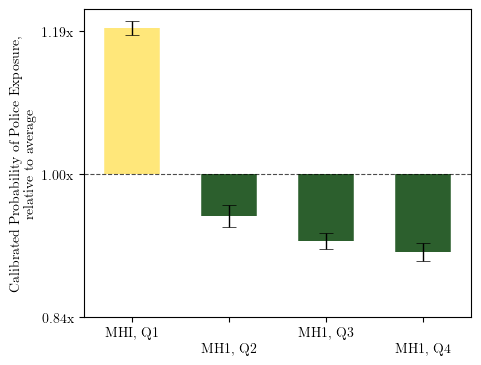

In [206]:
fig, ax = bootstrapped_plots(data_path=INCOME_RZONES_DATA_PATH, label_mapping=income_label_mapping)
plt.savefig(f'{PLOTS_PATH}/bootstrapped_income_rzones_plot.jpg', bbox_inches="tight")

## Disparities by NYC borough plot code

In [207]:
BOROUGH_DATA_PATH = f"{BOOTSTRAPS_PATH}/boro_bootstraps.json"

In [208]:
borough_label_mapping = {
    "Bronx_relative_to_average":            'The Bronx',
    "Brooklyn_relative_to_average":         'Brooklyn',
    "Manhattan_relative_to_average":        'Manhattan',
    "Queens_relative_to_average":           'Queens',
    "Staten Island_relative_to_average":    'Staten Island'
}

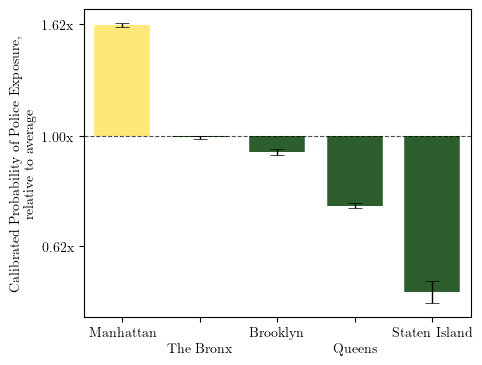

In [209]:
fig, ax = bootstrapped_plots(data_path=BOROUGH_DATA_PATH, label_mapping=borough_label_mapping)
plt.savefig(f'{PLOTS_PATH}/bootstrapped_borough_plot.jpg', bbox_inches="tight")

## Disparities by density quartile plot code

In [210]:
DENSITY_DATA_PATH = f"{BOOTSTRAPS_PATH}/density_cbg_bootstraps.json"

In [211]:
density_label_mapping = { 
    "density_cbg_quartile_1_relative_to_average":    "Density - Q1",
    "density_cbg_quartile_2_relative_to_average":    "Density - Q2",
    "density_cbg_quartile_3_relative_to_average":    "Density - Q3",
    "density_cbg_quartile_4_relative_to_average":    "Density - Q4"
}

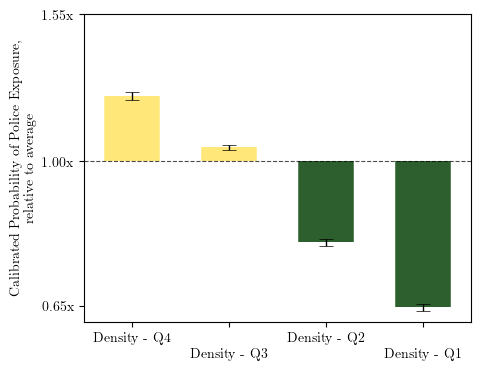

In [212]:
fig, ax = bootstrapped_plots(data_path=DENSITY_DATA_PATH, label_mapping=density_label_mapping)
plt.savefig(f'{PLOTS_PATH}/bootstrapped_density_plot.jpg', bbox_inches="tight")

## Disparities by density quartile (only residential zones) plot code

In [213]:
DENSITY_RZONES_DATA_PATH = f"{BOOTSTRAPS_PATH}/density_cbg_residential_only_bootstraps.json"

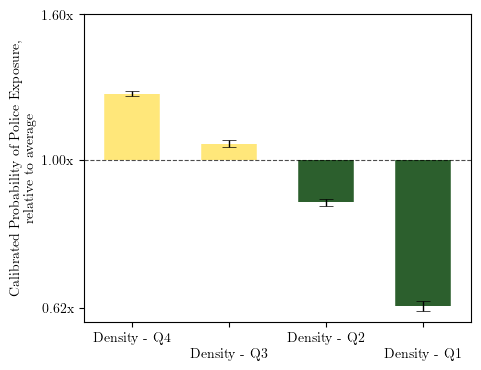

In [214]:
fig, ax = bootstrapped_plots(data_path=DENSITY_RZONES_DATA_PATH, label_mapping=density_label_mapping)
plt.savefig(f'{PLOTS_PATH}/bootstrapped_density_rzones_plot.jpg', bbox_inches="tight")

## Disparities by neighborhood tabulation area (NTA) plot code

In [215]:
NTA_DATA_PATH = f"{BOOTSTRAPS_PATH}/neighborhood_bootstraps.json"

In [216]:
nta_data = json.load(open(NTA_DATA_PATH))
list(nta_data['point_estimate'].keys())
ntas_keys = list(nta_data['point_estimate'].keys())
ntas_keys = [x for x in ntas_keys if 'relative_to_average' in x]
ntas = [x.replace('_relative_to_average', '') for x in ntas_keys]
nta_label_mapping = dict(zip(ntas_keys, ntas))


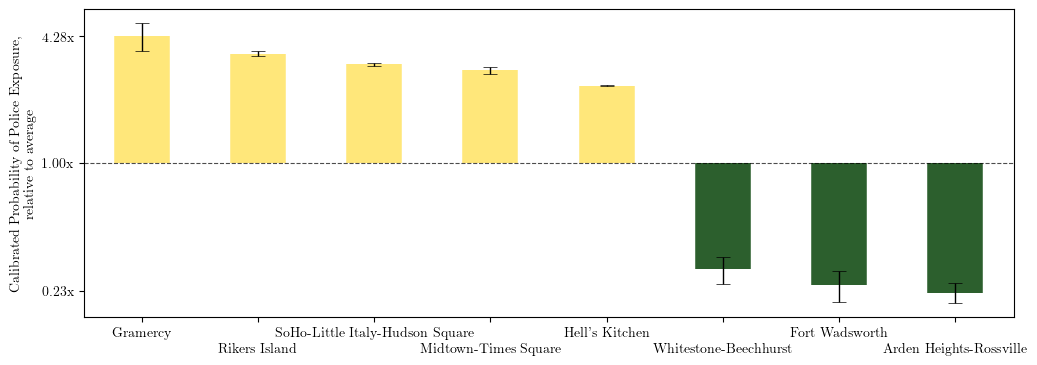

In [217]:
fig, ax = bootstrapped_plots(data_path=NTA_DATA_PATH, label_mapping=nta_label_mapping, firstn_filter=5, lastn_filter=3, figsize=(12,4))
plt.savefig(f'{PLOTS_PATH}/bootstrapped_ntas_plot.jpg', bbox_inches="tight")